In [1]:
#!/usr/bin/env python3.9
# coding=utf-8
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import requests as r

def _download_accidents(url: str = "http://ehw.fit.vutbr.cz/izv/accidents.pkl.gz", fname: str = "accidents.pkl.gz"):
    if not os.path.isfile(fname):
                    with r.get(url) as zips, open(fname, 'wb') as fp:
                        fp.write(zips.content)

                    
                    
_download_accidents()

In [2]:
def get_dataframe(filename: str, verbose: bool = False) -> pd.DataFrame:
    df = pd.read_pickle(filename)
    if verbose:
        mem = df.memory_usage(deep=True).sum() / (1024**2)
        print(f"orig_size: {mem:.1f} MB")

    convertable = ["p36", "p37", "weekday(p2a)", "p2b", "p6", "p7", "p8", "p9", "p10", "p11", "p12", "p13a",
                   "p13b", "p13c", "p14", "p15", "p16", "p17", "p18", "p19", "p20", "p21", "p22", "p23", "p24", "p27",
                   "p28",
                   "p34", "p35", "p39", "p44", "p45a", "p47", "p48a", "p49", "p50a", "p50b", "p51", "p52", "p53", "p55a",
                   "p57", "p58", "a", "b", "d", "e", "f", "g", "h", "i", "j", "k", "l", "n", "o", "p", "q", "r", "s", "t",
                   "p5a"]
    df['p2a'] = df['p2a'].astype('datetime64')
    df.rename({'p2a': 'date'}, inplace=True)
    df[convertable] = df[convertable].astype('category')

    if verbose:
        mem = df.memory_usage(deep=True).sum() / (1024**2)
        print(f"new_size:  {mem:.1f} MB")
    return df
df = get_dataframe("accidents.pkl.gz", verbose=True)

orig_size: 717.6 MB
new_size:  266.5 MB


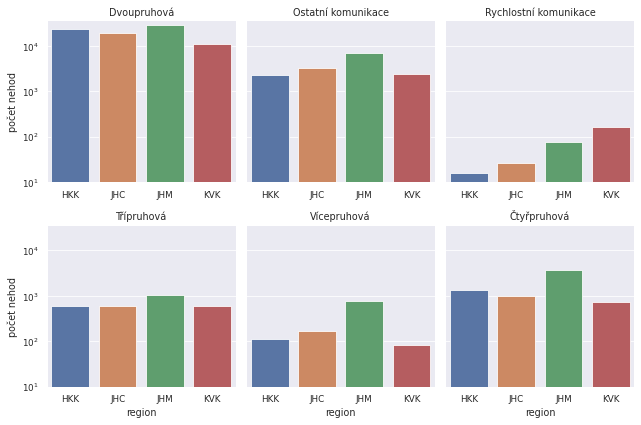

In [3]:
# Ukol 2: počty nehod v jednotlivých regionech podle druhu silnic
def plot_roadtype(df: pd.DataFrame, fig_location: str = None,
                  show_figure: bool = False):
    _rename = {
        0: 'Ostatní komunikace',
        1: 'Dvoupruhová',
        2: 'Třípruhová',
        3: 'Čtyřpruhová',
        4: 'Čtyřpruhová',
        5: 'Vícepruhová',
        6: 'Rychlostní komunikace',
    }
    df['hodnota'] = 1
    # make hard copy because of changing labels
    road_df = df.loc[:,['region', 'p21', 'hodnota']]
    road_df['p21'] = road_df['p21'].replace(_rename)
    road_df = pd.pivot_table(road_df, columns="region", index='p21', values='hodnota', aggfunc='sum')
    road_df = road_df[['HKK', 'JHC', 'JHM', 'KVK']]
    road_df = road_df.stack().reset_index(name='počet nehod')

    # graphing
    sns.set_theme()
    sns.set_context("paper")
    fig = sns.FacetGrid(road_df, col='p21',sharex=False, sharey=True, col_wrap=3)
    fig.map(sns.barplot, 'region', 'počet nehod', palette="deep", order=None).set(yscale='log', ylim=(10, None))
    fig.set_titles('{col_name}')
    fig.tight_layout()

    if fig_location:
        plt.savefig(fig_location)

    if show_figure:
        plt.show()
        plt.close()


plot_roadtype(df, fig_location="01_roadtype.png", show_figure=True)

In [4]:
# Ukol3: zavinění zvěří
def plot_animals(df: pd.DataFrame, fig_location: str = None,
                 show_figure: bool = False):
    pass
plot_animals(df, "02_animals.png", True)

In [5]:
# Ukol 4: Povětrnostní podmínky
def plot_conditions(df: pd.DataFrame, fig_location: str = None,
                    show_figure: bool = False):
    pass
plot_conditions(df, "03_conditions.png", True)